In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#installs

!pip install stellargraph
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 435 kB 9.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#imports 

from stellargraph import StellarGraph
import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification, DeepGraphCNN
import pandas as pd
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import math
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score, precision_score, confusion_matrix, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import warnings
warnings.filterwarnings("ignore")

Creating custom graph dataset

In [ ]:
combined_phenotype='/content/drive/MyDrive/SUPPLEMENTARY CODE/Data/Metadata/phenotypic_data.csv'
aug2_label = '/content/drive/MyDrive/SUPPLEMENTARY CODE/Data/Metadata/aug_labels.csv'
labels_mappings= pd.read_csv(combined_phenotype)
aug2_labels = pd.read_csv(aug2_label)

In [ ]:
def row_transform(arr, threshold):
  for i in range(len(arr)):
      arr[i] = arr[i] if arr[i]> threshold else abs(arr[i])+0.0001
  return arr

def binarize(df, threshold):
    df = df.transform(lambda x: row_transform(x, threshold))

In [ ]:
ub_02 = '/content/drive/MyDrive/SUPPLEMENTARY CODE/Data/Preprocessed Data/UCLA Binary 0_2'
uw = '/content/drive/MyDrive/SUPPLEMENTARY CODE/Data/Preprocessed Data/UCLA Weighted v2'

binary_features_02 = '/content/drive/MyDrive/SUPPLEMENTARY CODE/Data/Generated Features/UCLA Binary Local 0_2/'
weighted_features = '/content/drive/MyDrive/SUPPLEMENTARY CODE/Data/Generated Features/Weighted local feature files/'

uba = '/content/drive/MyDrive/SUPPLEMENTARY CODE/Data/Preprocessed Data/UCLA Augmented v1 Binary 0_2'
uwa = '/content/drive/MyDrive/SUPPLEMENTARY CODE/Data/Preprocessed Data/UCLA Augmented v1'

weighted_features_aug = '/content/drive/MyDrive/SUPPLEMENTARY CODE/Data/Generated Features/Local Weighted features - UCLA Aug/'
binary_features_aug = '/content/drive/MyDrive/SUPPLEMENTARY CODE/Data/Generated Features/Local Binary features -  UCLA Aug/'

uba1 = '/content/drive/MyDrive/SUPPLEMENTARY CODE/Data/Preprocessed Data/UCLA Augmented v2 Binary 0_2/'
uwa1 = '/content/drive/MyDrive/SUPPLEMENTARY CODE/Data/Preprocessed Data/UCLA Augmented v2/'

weighted_features_aug1 = '/content/drive/MyDrive/SUPPLEMENTARY CODE/Data/Generated Features/Local Weighted features- UCLA Aug v2/'
binary_features_aug1 = '/content/drive/MyDrive/SUPPLEMENTARY CODE/Data/Generated Features/Local Binary features - UCLA Aug v2/'

node2vec_features = '/content/drive/MyDrive/SUPPLEMENTARY CODE/Data/Generated Features/node2vec/'

In [ ]:
graphs_dir = [uba1, uba, ub_02]
feat_dir = [(binary_features_02, "binary_node_features_ucla_binary_"), (weighted_features, "weighted_node_features_")]
aug_feat_dir = [(binary_features_aug, "binary_node_features_"), (weighted_features_aug, "weighted_node_features_")]
aug_feat_dir1 = [(binary_features_aug1, "binary_node_features_"), (weighted_features_aug1, "weighted_node_features_")]

In [ ]:
graphs = list()
graph_labels = list()

# Graph creation
for directory in graphs_dir:
  for file in os.listdir(directory):
    if '(' in file:
        continue
    if file.endswith('.csv'):
      if (directory == ub_02):
          subject = file[12:16]
          if int(subject) == 2155:
            continue
      elif (directory == uw):
          subject = file[14:18]
      elif (directory == uba):
          subject = file[12:16]
          if int(subject) < 3125:
            continue
      elif (directory == uba1):
          subject = file[12:16]
      else:
        print("INVALID DIRECTORY")
        exit(0)

      # APPENDING LABEL
      subject = int(subject)
      print(subject)
      mask = labels_mappings['Subject'] == subject
      #only for aug v2
      if directory ==  uba1:
        if(labels_mappings[mask]['Label'].values[0]==0 or 
            (labels_mappings[mask]['Label'].values[0]!=aug2_labels.query("Subject==@subject")["assumed"].values[0])):
            continue
      graph_labels.append(labels_mappings[mask]['Label'].values[0])

      # APPENDING CORRESPONDING GRAPH
      df = pd.read_csv(directory+'/'+file, header=None)
      df = df.fillna(0)
      if directory == uba:
        for col in df:
          df[col] = df[col].astype(np.int64)
      G = nx.from_pandas_adjacency(df)          

      # Features
      if directory == uba: 
        if len(feat_dir) == 1:
          node_data = pd.read_csv(aug_feat_dir[0][0]+aug_feat_dir[0][1]+str(subject)+'.csv')
          node_data = node_data.drop(['Unnamed: 0'], axis=1, errors='ignore')
        else: 
          node_data_1 = pd.read_csv(aug_feat_dir[0][0]+aug_feat_dir[0][1]+str(subject)+'.csv')
          node_data_2 = pd.read_csv(aug_feat_dir[1][0]+aug_feat_dir[1][1]+str(subject)+'.csv')
          node_data_1 = node_data_1.drop(['Unnamed: 0'], axis=1, errors='ignore')
          node_data_2 = node_data_2.drop(['Unnamed: 0'], axis=1, errors='ignore')
          node_data = pd.merge(node_data_1, node_data_2, how = "inner", left_index=True, right_index=True)
      elif directory == uba1:
        if len(feat_dir) == 1:
          node_data = pd.read_csv(aug_feat_dir1[0][0]+aug_feat_dir1[0][1]+str(subject)+'.csv')
          node_data = node_data.drop(['Unnamed: 0'], axis=1, errors='ignore')
        else: 
          node_data_1 = pd.read_csv(aug_feat_dir1[0][0]+aug_feat_dir1[0][1]+str(subject)+'.csv')
          node_data_2 = pd.read_csv(aug_feat_dir1[1][0]+aug_feat_dir1[1][1]+str(subject)+'.csv')
          node_data_1 = node_data_1.drop(['Unnamed: 0'], axis=1, errors='ignore')
          node_data_2 = node_data_2.drop(['Unnamed: 0'], axis=1, errors='ignore')
          node_data = pd.merge(node_data_1, node_data_2, how = "inner", left_index=True, right_index=True) 
      else:
        if len(feat_dir) == 1:
          node_data = pd.read_csv(feat_dir[0][0]+feat_dir[0][1]+str(subject)+'.csv')
          node_data = node_data.drop(['Unnamed: 0'], axis=1, errors='ignore')
        else:
          node_data_1 = pd.read_csv(feat_dir[0][0]+feat_dir[0][1]+str(subject)+'.csv')
          node_data_2 = pd.read_csv(feat_dir[1][0]+feat_dir[1][1]+str(subject)+'.csv')
          node_data_1 = node_data_1.drop(['Unnamed: 0'], axis=1, errors='ignore')
          node_data_2 = node_data_2.drop(['Unnamed: 0'], axis=1, errors='ignore')
          node_data = pd.merge(node_data_1, node_data_2, how = "inner", left_index=True, right_index=True)

      node_data = node_data.drop(['subgraph centrality'], axis=1, errors='ignore')

      # Standardisation
      cols = list(node_data)
      scaler = StandardScaler().fit(node_data)
      node_data = scaler.transform(node_data)
      node_data = pd.DataFrame(node_data, columns = cols)
      
      g = StellarGraph.from_networkx(G,node_features=node_data)
      graphs.append(g)

4018
4021
4023
4014
4016
4019
4024
4022
4025
4009
4017
4000
4001
4006
4015
4005
4002
4003
4013
4008
4010
4007
4020
4004
4011
4012
4041
4043
4061
4066
4034
4032
4051
4069
4067
4029
4035
4037
4028
4039
4062
4060
4038
4058
4047
4055
4072
4075
4050
4048
4074
4042
4068
4026
4073
4057
4054
4064
4052
4033
4030
4045
4071
4040
4056
4065
4063
4053
4031
4070
4036
4059
4027
4049
4044
4046
4098
4113
4103
4107
4077
4120
4100
4109
4080
4086
4091
4078
4079
4093
4112
4111
4090
4089
4104
4101
4108
4087
4083
4097
4123
4118
4117
4114
4124
4085
4099
4102
4116
4084
4119
4096
4088
4106
4105
4121
4094
4125
4092
4082
4110
4081
4115
4122
4095
4147
4076
4169
4129
4128
4144
4150
4141
4142
4154
4165
4143
4146
4151
4137
4161
4156
4157
4133
4135
4167
4136
4168
4164
4127
4170
4148
4171
4166
4153
4158
4159
4139
4162
4145
4163
4149
4140
4130
4134
4126
4131
4160
4155
4138
4152
4132
3125
3126
3129
3128
3130
3133
3131
3135
3132
3134
3136
3138
3137
3139
3140
3141
3142
3144
3143
3146
3145
3148
3149
3147
3151
3152
3154
3155


In [ ]:
graph_labels = pd.DataFrame(graph_labels)

In [ ]:
graph_labels.value_counts().to_frame()

,0
0,
0,123
1,123


In [ ]:
graph_labels = pd.get_dummies(graph_labels, drop_first=True)

## DGCNN

In [ ]:
generator = PaddedGraphGenerator(graphs=graphs)

In [ ]:
es = EarlyStopping(monitor="val_acc", min_delta=0, patience=30, restore_best_weights=True)

In [ ]:
k = 20 
in_feat = 20
layer_sizes = [in_feat, 32, 64, 128, 128, 64, 32, 16, 4, 2]
dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["leaky_relu", "leaky_relu", "leaky_relu",  "leaky_relu", "leaky_relu", "leaky_relu", "leaky_relu", "leaky_relu", "leaky_relu", "log_softmax"],
    k=k,
    bias=True,
    generator=generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

Instructions for updating:
Use fn_output_signature instead


In [ ]:
x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)
x_out = Conv1D(filters=32, kernel_size=4, strides=1)(x_out)
x_out = Flatten()(x_out)
x_out = Dense(units=128, activation="leaky_relu")(x_out)
x_out = Dropout(rate=0.5)(x_out)

predictions = Dense(units=1, activation="sigmoid")(x_out)

In [ ]:
epochs=100

In [ ]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=Adam(learning_rate=0.0005), loss=binary_crossentropy, metrics=["acc"],
)

train_graphs, test_graphs = model_selection.train_test_split(graph_labels, train_size=0.80, test_size=0.20, stratify=graph_labels, random_state=3)
gen = PaddedGraphGenerator(graphs=graphs)

train_gen = gen.flow(
    list(train_graphs.index - 1),
    targets=train_graphs.values,
    batch_size=50,
    symmetric_normalization=True,
)

test_gen = gen.flow(
    list(test_graphs.index - 1),
    targets=test_graphs.values,
    batch_size=1,
    symmetric_normalization=True,
)

history = model.fit(train_gen, epochs=epochs, verbose=1, validation_data=test_gen, shuffle=True, callbacks=[es],)
test_metrics = model.evaluate(test_gen)

Epoch 1/100
4/4 [==============================] - 5s 692ms/step - loss: 0.6944 - acc: 0.4592 - val_loss: 0.6734 - val_acc: 0.6200
Epoch 2/100
4/4 [==============================] - 2s 407ms/step - loss: 0.6814 - acc: 0.5561 - val_loss: 0.6661 - val_acc: 0.7600
Epoch 3/100
4/4 [==============================] - 2s 408ms/step - loss: 0.6809 - acc: 0.6020 - val_loss: 0.6665 - val_acc: 0.6000
Epoch 4/100
4/4 [==============================] - 1s 391ms/step - loss: 0.6738 - acc: 0.6020 - val_loss: 0.6606 - val_acc: 0.5600
Epoch 5/100
4/4 [==============================] - 2s 410ms/step - loss: 0.6714 - acc: 0.5816 - val_loss: 0.6479 - val_acc: 0.7800
Epoch 6/100
4/4 [==============================] - 1s 392ms/step - loss: 0.6562 - acc: 0.6531 - val_loss: 0.6446 - val_acc: 0.7400
Epoch 7/100
4/4 [==============================] - 2s 421ms/step - loss: 0.6508 - acc: 0.6429 - val_loss: 0.6463 - val_acc: 0.6400
Epoch 8/100
4/4 [==============================] - 2s 403ms/step - loss: 0.6474 - a

In [ ]:
print("\nTest Set Metrics:")

print("Validation Accuracy: ", max(history.history['val_acc']))
print("Validation Loss: ", min(history.history['val_loss']))


Test Set Metrics:
Validation Accuracy:  0.7799999713897705
Validation Loss:  0.5600392818450928


In [ ]:
print("\nTraining Set Metrics:")

print("Accuracy: ", max(history.history['acc']))
print("Loss: ", min(history.history['loss']))


Training Set Metrics:
Accuracy:  0.7295918464660645
Loss:  0.5350872874259949


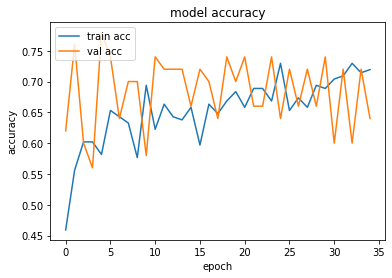

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train acc', 'val acc'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(test_gen)

50/50 [==============================] - 1s 6ms/step


In [ ]:
y_pred = []
y_true = []
x = np.array(pred)
for i in x:
  if i <0.5:
    y_pred.append(0)
  else:
    y_pred.append(1)

for t in test_gen.targets:
    y_true.append(t[0])

In [ ]:
from sklearn import metrics

f1_score = metrics.f1_score(y_true, y_pred)
precision = metrics.precision_score(y_true, y_pred)
recall =  metrics.recall_score(y_true, y_pred)
accuracy = metrics.accuracy_score(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn+fp)

In [ ]:
print("Metrics:")

print("Accuracy: ", accuracy)
print("f1 score: ", f1_score)
print("precision: ", precision)
print("recall: ", recall)
print("specificity ", specificity)

Metrics:
Accuracy:  0.78
f1 score:  0.7555555555555556
precision:  0.85
recall:  0.68
specificity  0.88


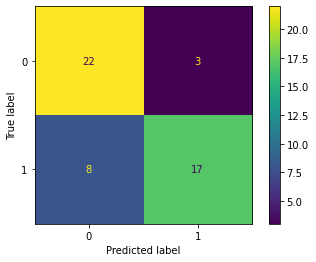

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred), display_labels=[0,1])
disp.plot()